# Solver Graph

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import operator
from typing import Annotated, List, Literal, Optional

from pydantic import BaseModel, Field


class TestInputAndOutput(BaseModel):
    """Test input and expected output for the programming puzzle."""

    test_input: Optional[str] = Field(
        default=None, description="The actual test input."
    )
    expected_output: Optional[int] = Field(
        default=None, description="The expected output of the test input."
    )


class Solution(BaseModel):
    code: str = Field(description="Code that solves the given puzzle.")
    model_name: str = Field(description="The model that created the solution.")


class SolutionEvaluation(BaseModel):
    solution_idx: int = Field(description="Index of the solution.", ge=0)
    criterion: str = Field(description="Criterion, the solution is evaluated by.")
    score: int = Field(description="Score of the solution.", ge=0, le=10)


class SolutionsEvaluations(BaseModel):
    solutions_evaluations: List[SolutionEvaluation] = Field(
        description="List of evaluations of all solutions."
    )


class OverallState(BaseModel):
    year: int = Field(description="Year of chosen Advent of Code.", ge=2015, le=2024)
    day: int = Field(description="Day of chosen Advent of Code (1-25).", ge=1, le=25)
    programming_language: Literal["Python", "JavaScript", "TypeScript"] = Field(
        description="The programming language, the puzzle should be solved in."
    )

    puzzle_url: Optional[str] = Field(
        default=None, description="The URL to the chosen Advent of Code puzzle."
    )
    puzzle_description: Optional[str] = Field(
        default=None, description="The puzzle description."
    )

    test_input_and_output: Optional[TestInputAndOutput] = Field(
        default=None,
        description="The test input with expected output for the given puzzle.",
    )

    solutions: Annotated[List[Solution], operator.add] = Field(
        default=[], description="A list of all solutions that solve the given puzzle."
    )
    tested_solutions: Annotated[List[Solution], operator.add] = Field(
        default=[],
        description="A list of tested solutions that solve the given puzzle.",
    )

    evaluations: Annotated[List[SolutionsEvaluations], operator.add] = Field(
        default=[], description="A list of all evaluations of all solutions."
    )
    best_solution_idx: Optional[int] = Field(
        default=None, description="The index of the best solution code."
    )
    best_solution: Optional[str] = Field(
        default=None, description="The best code to solve the given puzzle."
    )

In [3]:
def get_advent_of_code_url(year: int, day: int) -> str:
    return f"https://adventofcode.com/{year}/day/{day}"


def get_puzzle_url(state: OverallState) -> OverallState:
    return {"puzzle_url": get_advent_of_code_url(state.year, state.day)}

In [4]:
from langchain_community.document_loaders import WebBaseLoader


def get_visible_content_of_website(url: str) -> str:
    loader = WebBaseLoader(
        web_path=url, bs_get_text_kwargs={"separator": " ", "strip": True}
    )
    document = loader.load()[0]
    return document.page_content


def get_puzzle_description(state: OverallState) -> OverallState:
    return {"puzzle_description": get_visible_content_of_website(state.puzzle_url)}

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI


def get_puzzle_test_input_and_output(state: OverallState) -> OverallState:
    model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
    structured_model = model.with_structured_output(schema=TestInputAndOutput)

    messages = [
        SystemMessage(
            content=(
                "You are an expert extraction algorithm. "
                "Only extract relevant information from the text. "
                "If you do not know the value of an attribute asked to extract, "
                "return null for the attribute's value.",
            )
        ),
        HumanMessage(
            content=(
                f"The full puzzle description is:\n"
                "```\n"
                f"{state.puzzle_description}"
                "```"
            )
        ),
    ]

    test_input_and_output = structured_model.invoke(messages)
    return {"test_input_and_output": test_input_and_output}

In [6]:
from typing import List

from langchain_core.language_models import BaseChatModel
from langchain_google_genai import ChatGoogleGenerativeAI


def get_models() -> List[BaseChatModel]:
    return [
        ChatGoogleGenerativeAI(model="gemini-1.5-pro"),
        ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
        ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b"),
    ]

In [7]:
import re
from functools import partial
from typing import Callable, Optional

from langchain_core.language_models import BaseChatModel
from langchain_core.messages import HumanMessage, SystemMessage


def extract_actual_code(raw_code: str) -> Optional[str]:
    regex = r"```(python|typescript|javascript|js|ts)\\n(?P<code>.*)\\n```(\\n)?"
    pattern = re.compile(regex)
    match = pattern.search(raw_code)
    if match:
        return match.group("code")
    else:
        return None


def solve_puzzle(state: OverallState, model: BaseChatModel) -> Solution:
    messages = [
        SystemMessage(
            content=(
                "You are a helpful assistant tasked with solving programming puzzles. "
                "You should only return the actual code. "
                "You should write a function called `solve`, which takes one input (the puzzle input), and returns the solution to the problem in a meaningful type or format. "
                "This `solve` function will be used to test the code and solve the actual puzzle. "
                "The code should be directly runnable. "
                "The code should not use libraries outside of the standard libraries. "
                "You can create helper functions, if helpful. "
                "All descriptions must be part of comments within the code itself."
            )
        ),
        HumanMessage(
            content=(
                f"Solve the following puzzle in the '{state.programming_language}' programming language:\n"
                "```\n"
                f"{state.puzzle_description}"
                "```"
            )
        ),
    ]

    raw_code = model.invoke(messages).content
    code = extract_actual_code(raw_code)

    if code:
        solution = {
            "code": code,
            "model_name": model.model,
        }
        solutions = [solution]
    else:
        solutions = []

    return {"solutions": solutions}


def get_solve_puzzle_node(
    model: BaseChatModel,
) -> Callable[[OverallState], OverallState]:
    return partial(solve_puzzle, model=model)


def get_solve_puzzle_node_name(name: str) -> str:
    return f"solve_puzzle_using_{name}"

In [8]:
import re
import subprocess
import sys
import tempfile
from typing import Callable, Optional


def _get_wrapped_code(input_file_name: str, code: str) -> str:
    return f"""
{code}

output = solve("{input_file_name}")

print("RESULT: " + str(output))
"""


def run_code(code: str, input_data: str) -> Optional[int]:
    with tempfile.NamedTemporaryFile(mode="w", suffix=".txt") as input_file:
        input_file.write(input_data)
        input_file.flush()

        wrapped_code = _get_wrapped_code(input_file.name, code)

        with tempfile.NamedTemporaryFile(mode="w", suffix=".py") as code_file:
            code_file.write(wrapped_code)
            code_file.flush()

            completed_process = subprocess.run(
                [sys.executable, code_file.name], capture_output=True, text=True
            )

            if completed_process.returncode == 0 and completed_process.stdout:
                regex = r"RESULT: (?P<output>\d+)"
                pattern = re.compile(regex, re.MULTILINE)
                match = pattern.search(completed_process.stdout)
                if match:
                    return int(match.group("output"))
            return None


def solution_passes_test(
    solution: Solution, test_input_and_output: TestInputAndOutput
) -> bool:
    actual_test_output = run_code(solution.code, test_input_and_output.test_input)
    return actual_test_output == test_input_and_output.expected_output


def test_solutions(state: OverallState) -> OverallState:
    tested_solutions = [
        solution
        for solution in state.solutions
        if solution_passes_test(solution, state.test_input_and_output)
    ]
    return {"tested_solutions": tested_solutions}

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI


def get_criterions() -> List[str]:
    return ["efficiency", "readability", "maintainability"]


def evaluate_solutions(state: OverallState, criterion: str) -> OverallState:
    solutions_text = ""
    for idx, solution in enumerate(state.tested_solutions):
        solutions_text += f"Solution {idx}:\n" "'''\n" f"{solution.code}" "'''\n" "\n"

    messages = [
        SystemMessage(
            content=(
                "You are a helpful assistant tasked with evaluating solutions to programming puzzles. "
                "You will get a list of solutions (code). "
                "You evaluate the solutions according to a given criterion. "
                "The actual evaluation is a number between 0 (worst) and 10 (best)."
            )
        ),
        HumanMessage(
            content=(
                "Given the following programming puzzle description: \n"
                "```\n"
                f"{state.puzzle_description}"
                "```\n"
                "\n"
                f"Also given the following solutions in the {state.programming_language} programming language:\n"
                "```\n"
                f"{solutions_text}"
                "```\n"
                "\n"
                f"Evaluate the solutions according to the criterion '{criterion}'."
            )
        ),
    ]

    model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
    model_with_structured_output = model.with_structured_output(SolutionsEvaluations)
    solution_evaluations = model_with_structured_output.invoke(messages)
    return {"evaluations": [solution_evaluations]}


def get_evaluate_solutions_node(
    criterion: str,
) -> Callable[[OverallState], OverallState]:
    return partial(evaluate_solutions, criterion=criterion)


def get_evaluate_solutions_node_name(criterion: str) -> str:
    return f"evaluate_solutions_regarding_{criterion}"

In [10]:
from collections import defaultdict


def aggregate_evaluations(state: OverallState) -> OverallState:
    overall_scores = defaultdict(int)
    for solutions_evaluations in state.evaluations:
        for evaluation in solutions_evaluations.solutions_evaluations:
            overall_scores[evaluation.solution_idx] += evaluation.score
    sorted_overall_scores = sorted(
        [
            (overall_score, solution_idx)
            for solution_idx, overall_score in overall_scores.items()
        ],
        key=lambda t: t[0],
        reverse=True,
    )
    best_solution_idx = sorted_overall_scores[0][1]
    return {
        "best_solution_idx": best_solution_idx,
        "best_solution": state.tested_solutions[best_solution_idx],
    }

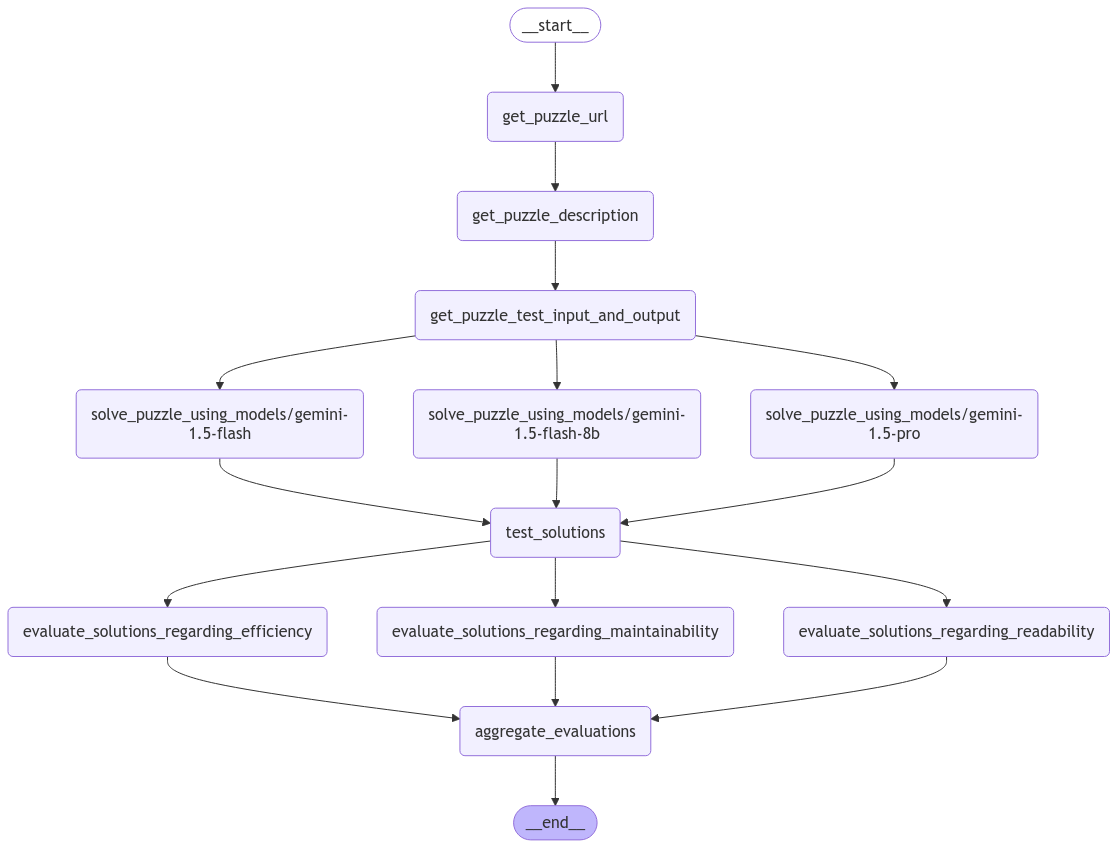

In [11]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.graph.graph import CompiledGraph


def create_graph() -> CompiledGraph:
    workflow = StateGraph(OverallState)

    # Nodes
    workflow.add_node("get_puzzle_url", get_puzzle_url)
    workflow.add_node("get_puzzle_description", get_puzzle_description)
    workflow.add_node(
        "get_puzzle_test_input_and_output", get_puzzle_test_input_and_output
    )
    for model in get_models():
        workflow.add_node(
            get_solve_puzzle_node_name(model.model), get_solve_puzzle_node(model)
        )
    workflow.add_node("test_solutions", test_solutions)

    for criterion in get_criterions():
        workflow.add_node(
            get_evaluate_solutions_node_name(criterion),
            get_evaluate_solutions_node(criterion),
        )
    workflow.add_node("aggregate_evaluations", aggregate_evaluations)

    # Edges
    workflow.add_edge(START, "get_puzzle_url")
    workflow.add_edge("get_puzzle_url", "get_puzzle_description")
    workflow.add_edge("get_puzzle_description", "get_puzzle_test_input_and_output")

    for model in get_models():
        node_name = get_solve_puzzle_node_name(model.model)
        workflow.add_edge("get_puzzle_test_input_and_output", node_name)
        workflow.add_edge(node_name, "test_solutions")

    for criterion in get_criterions():
        node_name = get_evaluate_solutions_node_name(criterion)
        workflow.add_edge("test_solutions", node_name)
        workflow.add_edge(node_name, "aggregate_evaluations")
    workflow.add_edge("aggregate_evaluations", END)

    graph = workflow.compile()
    return graph


graph = create_graph()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"year": 2024, "day": 3, "programming_language": "Python"})